In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import ParetoStarPrior
from smc.images import ImageModel
from smc.kernel import SingleComponentMALA
from smc.aggregate import Aggregate

import torch
from utils.misc import select_cuda_device

import matplotlib.pyplot as plt

device = select_cuda_device()
torch.cuda.set_device(device)
torch.set_default_device(device)

Selected device 0, which has 11001 MB available.


We specify a prior and an image model and generate one image.

count
 21 
fluxes
 [2539.8 1443.4 1101.4  714.5  870.3 1789.7 1484.1 1158.2  928.7  792.1
  820.3 4893.3  738.6 1881.5 2230.8 4185.9  752.6  796.   857.4 1160.7
  777.9    0.     0.     0.     0.     0.     0.     0.     0.     0. ] 
locs
 [[ 0.2 19.3]
 [19.   2.9]
 [25.   1.5]
 [ 3.1 28. ]
 [ 2.6  3.5]
 [25.7  3.4]
 [28.6 19.8]
 [ 5.4 17.3]
 [14.7 30.4]
 [31.2 28.6]
 [23.1  1.6]
 [26.9 27.7]
 [ 4.  25. ]
 [ 9.8 16.9]
 [ 8.3  8.1]
 [ 4.3 31.5]
 [10.  11.6]
 [14.9  9.9]
 [ 2.  10.9]
 [19.9 14.5]
 [25.5 21.1]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [-0.  -0. ]
 [ 0.   0. ]
 [-0.   0. ]
 [ 0.   0. ]
 [ 0.  -0. ]
 [-0.   0. ]] 




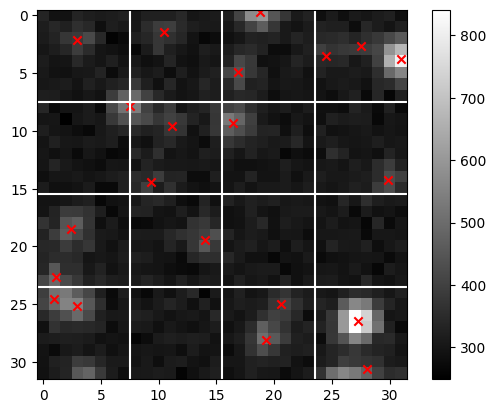

In [2]:
torch.manual_seed(0)

image_dim = 32
true_psf_stdev = 1.15
true_background = 300
true_flux_scale = 700
true_flux_alpha = 2.0

TruePrior = ParetoStarPrior(max_objects = 30,
                            image_height = image_dim,
                            image_width = image_dim,
                            flux_scale = true_flux_scale,
                            flux_alpha = true_flux_alpha,
                            pad = 2)

TrueImageModel = ImageModel(image_height = image_dim,
                            image_width = image_dim,
                            psf_stdev = true_psf_stdev,
                            background = true_background)

true_counts, true_locs, true_fluxes, images = TrueImageModel.generate(Prior = TruePrior,
                                                                      num_images = 1)

print(f"count\n", true_counts[0].round().item(),
      "\nfluxes\n", true_fluxes[0].round(decimals=1).cpu().numpy(),
      "\nlocs\n", true_locs[0].round(decimals=1).cpu().numpy(), "\n\n")
fig, ax = plt.subplots(1,1)
tmp = ax.imshow(images[0].cpu(), cmap = 'gray')
_ = fig.colorbar(tmp)
_ = ax.scatter(true_locs.squeeze()[:true_counts.squeeze(),1].cpu() - 0.5,
               true_locs.squeeze()[:true_counts.squeeze(),0].cpu() - 0.5, marker = 'x', color = 'red')
_ = ax.vlines(x = image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
_ = ax.vlines(x = 2*image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
_ = ax.vlines(x = 3*image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
_ = ax.hlines(y = image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')
_ = ax.hlines(y = 2*image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')
_ = ax.hlines(y = 3*image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')

We set the side length of the tiles on which we will run the sampler, and we specify a prior and image model at the tile level. We also specify a Metropolis-Hastings kernel to be used within the SMC sampler.

We'll assume that the image background, PSF standard deviation, and flux prior parameters are all well modeled.

In [3]:
tile_dim = 8

TilePrior = ParetoStarPrior(max_objects = 5,
                            image_height = tile_dim,
                            image_width = tile_dim,
                            flux_scale = true_flux_scale,
                            flux_alpha = true_flux_alpha,
                            pad = 2)

TileImageModel = ImageModel(image_height = tile_dim,
                            image_width = tile_dim,
                            psf_stdev = true_psf_stdev,
                            background = true_background)

MALAKernel = SingleComponentMALA(max_iters = 100,
                                 sqjumpdist_tol = 1e-2,
                                 locs_step = 0.25,
                                 fluxes_step = 250,
                                 fluxes_min = true_flux_scale,
                                 fluxes_max = 1e9)

We initialize an `SMCsampler` object and run it on the tiles.

In [4]:
sampler = SMCsampler(image = images[0],
                     tile_dim = tile_dim,
                     Prior = TilePrior,
                     ImageModel = TileImageModel,
                     MutationKernel = MALAKernel,
                     num_catalogs_per_count = 200,
                     ess_threshold = 150,
                     resample_method = "multinomial",
                     max_smc_iters = 100)

print(f"True count: {true_counts[0]}")
print(f"True total flux: {true_fluxes[0].sum()}\n")

sampler.run()

True count: 21
True total flux: 31917.435546875

starting the tile samplers...
iteration 5, temperature = 0.005766833201050758
iteration 10, temperature = 0.017932280898094177
iteration 15, temperature = 0.054119084030389786
iteration 20, temperature = 0.14782321453094482
iteration 25, temperature = 0.3702404499053955
done!



Now we instantiate an `Aggregate` object with the tile-level SMC results.

In [5]:
aggMALA = SingleComponentMALA(max_iters = 50,
                              sqjumpdist_tol = 1e-1,
                              locs_step = 0.1,
                              fluxes_step = 100,
                              fluxes_min = true_flux_scale,
                              fluxes_max = 1e9)

In [6]:
agg = Aggregate(sampler.Prior,
                sampler.ImageModel,
                aggMALA,
                sampler.tiled_image,
                sampler.counts,
                sampler.locs,
                sampler.fluxes,
                sampler.weights_intercount,
                resample_method = "multinomial",
                merge_method = "naive",
                merge_multiplier = 1,
                ess_threshold = (sampler.Prior.max_objects + 1) * sampler.ess_threshold)

We run the aggregation procedure to obtain image-level catalogs.

In [7]:
agg.run()
agg.summarize()

aggregating tile catalogs...
level 0
iteration 5, temperature = 0.16235923767089844
iteration 10, temperature = 0.5275211930274963
level 1
iteration 5, temperature = 0.10684932768344879
iteration 10, temperature = 0.342040479183197
iteration 15, temperature = 0.7824153304100037
level 2
iteration 5, temperature = 0.33477428555488586
iteration 10, temperature = 0.7319678664207458
level 3
iteration 5, temperature = 0.23743653297424316
iteration 10, temperature = 0.5097514390945435
iteration 15, temperature = 0.8823530673980713
done!

summary:
posterior distribution of number of stars:
tensor([20, 21, 22, 23, 24, 25, 26])
tensor([0.0180, 0.1270, 0.3320, 0.1800, 0.1650, 0.1260, 0.0530])

posterior mean total flux = 32307.96875

number of unique catalogs = 753


We visually examine the posterior distribution of the total flux. The dotted black line is the true total flux.

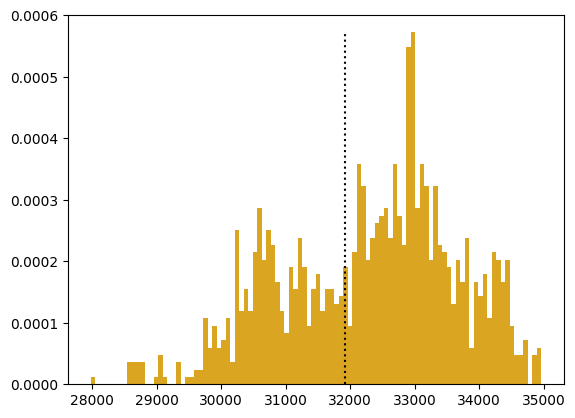

In [8]:
tmp = plt.hist(agg.fluxes[0,0].sum(-1).detach().cpu(), bins = 100, density = True, color = 'goldenrod')
_ = plt.vlines(x = true_fluxes.sum().cpu(), ymin = 0, ymax = tmp[0].max(), color = 'black', linestyle = 'dotted')

We can also reconstruct the image using three of our posterior samples.

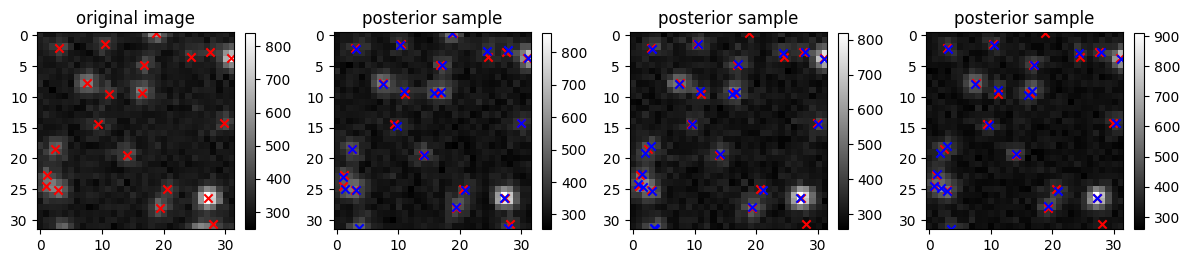

In [9]:
fig, ax = plt.subplots(1, 4, figsize = (12,4))
tmp = ax[0].imshow(images[0].cpu(), cmap = 'gray')
_ = fig.colorbar(tmp, fraction = 0.045)
_ = ax[0].set_title('original image')
_ = ax[0].scatter(true_locs.squeeze()[:true_counts.squeeze(),1].cpu() - 0.5,
                  true_locs.squeeze()[:true_counts.squeeze(),0].cpu() - 0.5, marker = 'x', color = 'red')

for j in range(1,4):
    index = torch.randint(low = 0, high = agg.counts.shape[-1] - 1, size = [1])
    psf = agg.ImageModel.psf(agg.locs.detach()[:,:,index])
    rate = (psf * agg.fluxes[:,:,index].unsqueeze(-3).unsqueeze(-4)).sum(-1) + agg.ImageModel.background
    reconstruction = torch.distributions.Poisson(rate).sample().squeeze([0,1]).permute((2,0,1))
    tmp = ax[j].imshow(reconstruction[0].cpu(), cmap = 'gray')
    _ = ax[j].set_title('posterior sample')
    _ = fig.colorbar(tmp, fraction = 0.045)
    _ = ax[j].scatter(true_locs.squeeze()[:true_counts.squeeze(),1].cpu() - 0.5,
                    true_locs.squeeze()[:true_counts.squeeze(),0].cpu() - 0.5, marker = 'x', color = 'red')
    _ = ax[j].scatter(agg.locs.detach().squeeze()[index,:agg.counts.squeeze()[index],1].cpu() - 0.5,
                    agg.locs.detach().squeeze()[index,:agg.counts.squeeze()[index],0].cpu() - 0.5, marker = 'x', color = 'blue')

fig.tight_layout()